# Création d'un panorama

L'objectif de ce TP est de créer un panorama à partir de plusieurs images, en utilisant les principales notions vues en cours. 
On essaiera de construire des panoramas d'images de l'école (intérieur ou extérieur) 
et votre premier travail consistera donc à faire un série de clichés (à l'aide de votre téléphone par exemple) de la partie de l'école que vous souhaitez *reconstruire*. 
Il faudra bien faire attention à faire en sorte que vos images se recouvrent partiellement.

Le principe est relativement simple et suit l'approche vue en cours :

 + Une première étape est de décider quelle sera votre image source et quelles seront vos images destination (i.e les images que vous voulez mettre en correspondance avec votre image source).
 
 + Une fois l'image source choisie, une technique pour la création de panorama est de placer cette image dans un plus gros canevas (image de plus grande taille dont les pixels non connus seront mis à noir). 
 La fonction [**warpAffine**]( https://docs.opencv.org/3.4.0/da/d6e/tutorial_py_geometric_transformations.html) d'OpenCV pourrait être utilisée pour cela.

 + L'étape d'après consiste à la détection et à la description d'un ensembles de points caractéristiques pour l'image cible transformée et l'ensemble des images destination. 
 Vous pourrez pour cela utiliser les descripteurs [SIFT](https://docs.opencv.org/3.3.0/da/df5/tutorial_py_sift_intro.html).
 
 + Il s'agira ensuite de mettre en correspondance les descripteurs de l'image source avec ceux de l'image destination. 
 Ici aussi vous pouvez utiliser plusieurs outils de [mattching](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html) fournis par la bibliothèque OpenCV.
 
 + Seuls les 200 meilleures mises en correspondance seront gardées pour la suite.
 
 + A partir de ces mises en correspondance, il faut ensuite calculer l'homographie permettant de passer de l'image sources à l'image destination. 
 Seuls 4 mises en correspondance sont nécessaire pour calculer cette homographie mais il est usuel d'en utiliser plus avec l'approche RANSAC, disponible dans Opencv 
 (documentation [ici](https://docs.opencv.org/3.4.0/d9/dab/tutorial_homography.html)) comme un paramètre de la fonction **findHomography**).
 
 + Appliquer l'homographie obtenue à l'image destination.
 
 + Fusionner l'image cible et l'image destination.
 

In [3]:
%matplotlib inline
import numpy as np
import cv2 
from matplotlib import pyplot as plt

In [4]:
img = cv2.imread('./Data/Lab5/pano1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

(3000, 4000, 3)


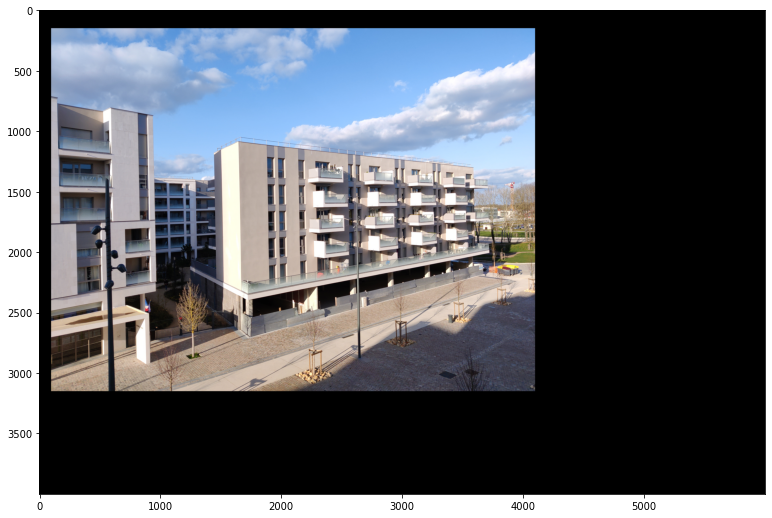

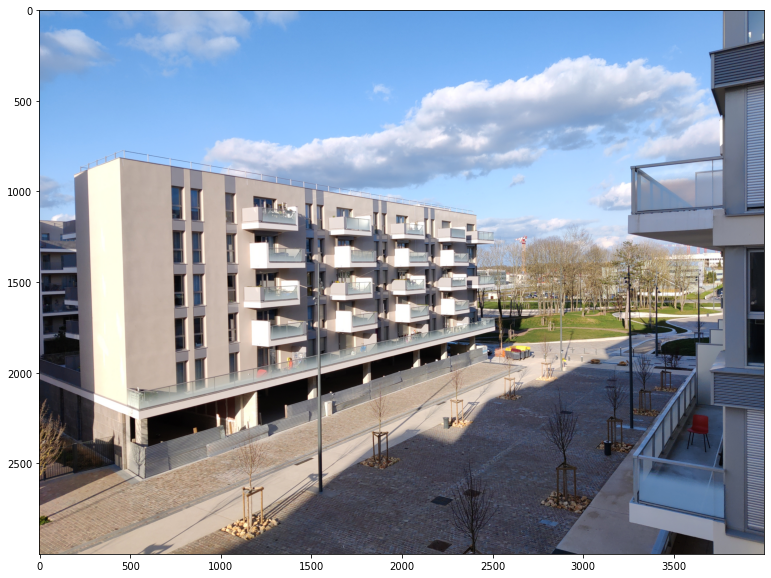

In [25]:
# ETAPE 1
M = np.float32([[1,0,100],[0,1,150]])
sourcedst = cv2.warpAffine(rgb,M,(2*img.shape[0],1*img.shape[1]))

plt.figure(figsize=(13,10))
plt.imshow(sourcedst)
plt.show()

imgdest = cv2.imread('./Data/Lab5/pano2.jpg')
rgbdest = cv2.cvtColor(imgdest, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(13,10))
plt.imshow(rgbdest)
plt.show()

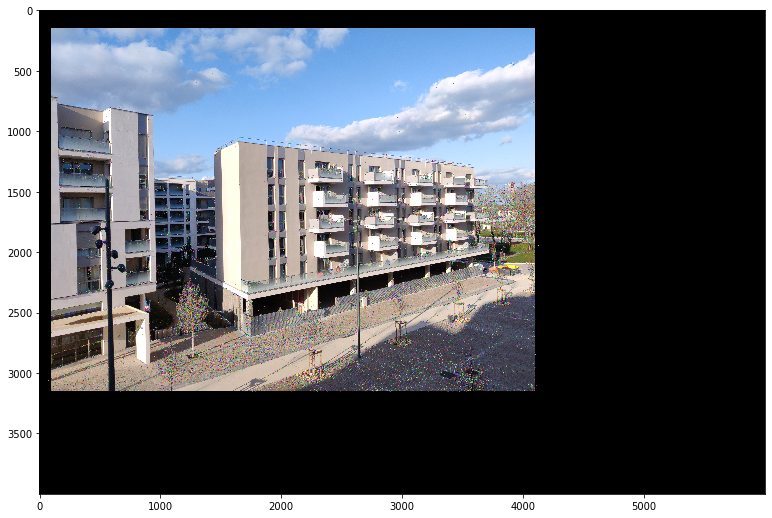

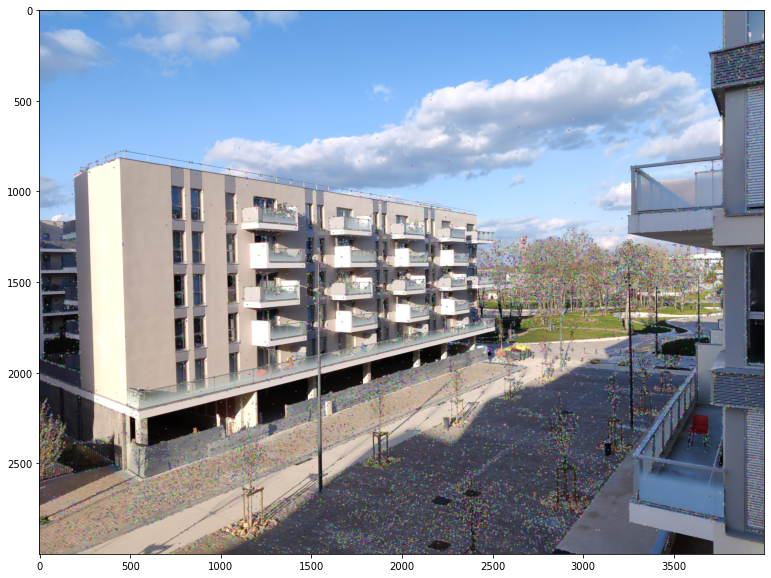

In [23]:
# ETAPE 2 

sift1 = cv2.xfeatures2d.SIFT_create()
kp, des = sift1.detectAndCompute(sourcedst,None)

sourcedst=cv2.drawKeypoints(sourcedst,kp,sourcedst)
cv2.imwrite('sift_keypoints_pano1.jpg',sourcedst)

plt.figure(figsize=(13,10))
plt.imshow(sourcedst,interpolation='nearest')
plt.show()

sift2 = cv2.xfeatures2d.SIFT_create()
kp2, des2 = sift2.detectAndCompute(rgbdest,None)

rgbdest=cv2.drawKeypoints(rgbdest,kp2,rgbdest)
plt.figure(figsize=(13,10))
plt.imshow(rgbdest)
plt.show()

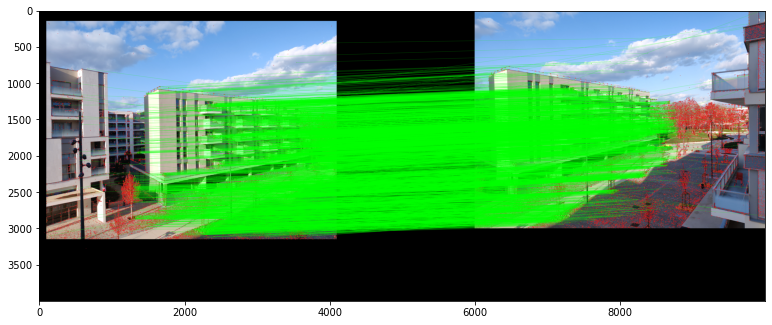

In [20]:
# ETAPE 3 : matching

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des,des2,k=2)


# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(sourcedst,kp,rgbdest,kp2,matches,None,**draw_params)

plt.figure(figsize=(13,10))
plt.imshow(img3,)
plt.show()

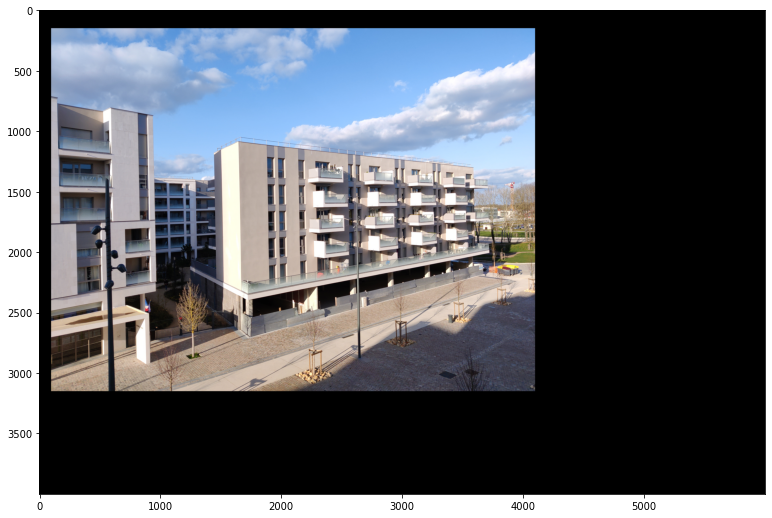

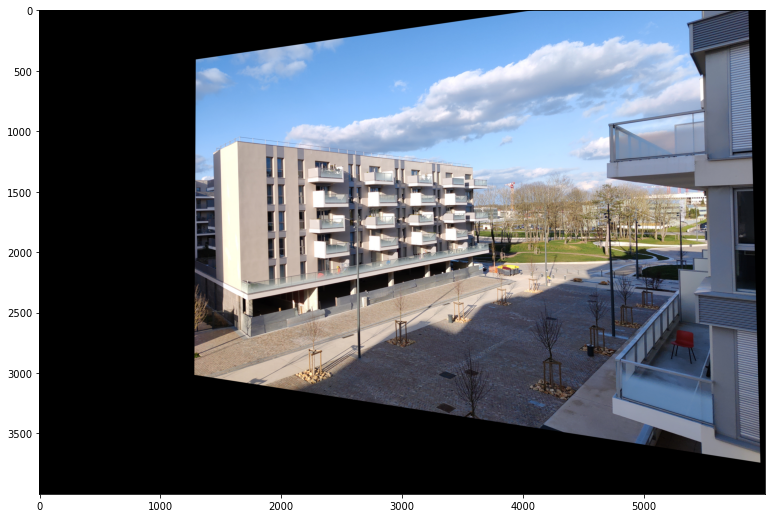

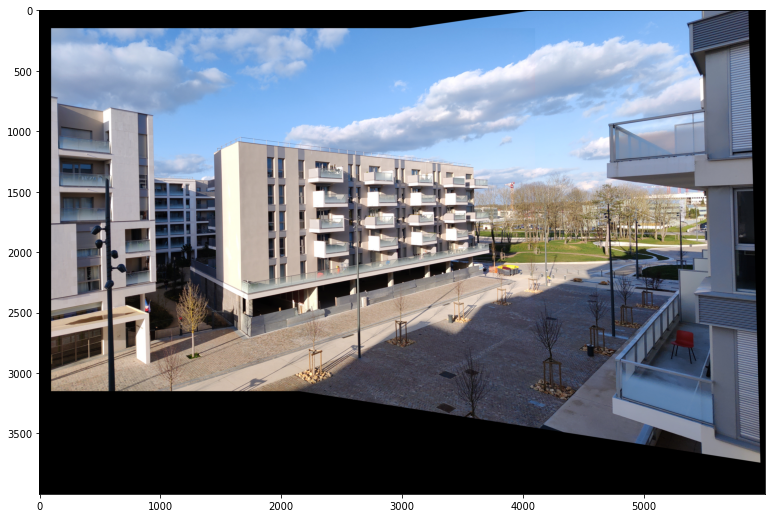

In [26]:
# ETAPE 4
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>10:
    src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
    warp_img = cv2.warpPerspective(rgbdest, M, (sourcedst.shape[1], sourcedst.shape[0]))
    plt.figure(figsize=(13,10))
    plt.imshow(sourcedst)
    plt.show()
    plt.figure(figsize=(13,10))
    plt.imshow(warp_img)
    plt.show()
    blacks = sourcedst==0
    result = np.copy(sourcedst)
    result[blacks] = warp_img[blacks]
    plt.figure(figsize=(13,10))
    plt.imshow(result)
    plt.show()
